In [114]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from scipy.stats import zscore
import warnings
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing
from pmdarima import auto_arima

warnings.filterwarnings("ignore")

In [115]:
colspecs = [(2, 10), (10, 22), (56, 69), (82, 95)]
names = ['Data', 'Codigo', 'Preco_Abertura', 'Preco_Fechamento']

# Carrega os arquivos de 2023 e 2022
df_teste = pd.read_fwf('COTAHIST_A2024.TXT', colspecs=colspecs, names=names, header=None)
df_2023 = pd.read_fwf('COTAHIST_A2023.TXT', colspecs=colspecs, names=names, header=None)
df_2022 = pd.read_fwf('COTAHIST_A2022.TXT', colspecs=colspecs, names=names, header=None)


# Concatena os DataFrames
df_treino = pd.concat([df_2022, df_2023])
df_treino = df_treino.dropna()
df_teste = df_teste.dropna()


# Filtra as linhas referentes à ação
acao = "DISB34"
df_treino = df_treino[df_treino['Codigo'].str.endswith(acao)]
df_teste = df_teste[df_teste['Codigo'].str.endswith(acao)]

print(df_treino)
print(df_teste)


             Data    Codigo  Preco_Abertura  Preco_Fechamento
1704     20220203  02DISB34          4965.0            4924.0
2492     20220103  02DISB34          5790.0            5790.0
4629     20220221  02DISB34          5201.0            4970.0
4979     20220119  02DISB34          5627.0            5447.0
8268     20220204  02DISB34          4900.0            4900.0
...           ...       ...             ...               ...
1345721  20231221  34DISB34          3000.0            2963.0
1347099  20231222  34DISB34          2996.0            2932.0
1349131  20231226  34DISB34          2942.0            2918.0
1350649  20231227  34DISB34          2930.0            2896.0
1352402  20231228  34DISB34          2903.0            2903.0

[498 rows x 4 columns]
            Data    Codigo  Preco_Abertura  Preco_Fechamento
1137    20240102  34DISB34          2914.0            2914.0
2944    20240103  34DISB34          2981.0            2956.0
4345    20240104  34DISB34          3011.0       

In [116]:
df_treino['Data'] = pd.to_datetime(df_treino['Data'], format='%Y%m%d')

# Extraindo ano, mês e dia do df de treino
df_treino['Ano'] = df_treino['Data'].dt.year
df_treino['Mes'] = df_treino['Data'].dt.month
df_treino['Dia'] = df_treino['Data'].dt.day
df_treino = df_treino.sort_values(by='Data')
df_teste['Data'] = pd.to_datetime(df_teste['Data'], format='%Y%m%d')

# Extraindo ano, mês e dia do df de teste
df_teste['Ano'] = df_teste['Data'].dt.year
df_teste['Mes'] = df_teste['Data'].dt.month
df_teste['Dia'] = df_teste['Data'].dt.day
df_treino = df_treino.sort_values(by='Data')

df_treino = df_treino.sort_values(by='Data')
df_treino.set_index(df_treino['Data'],inplace=True)
df_teste = df_teste.sort_values(by='Data')
df_teste.set_index(df_teste['Data'],inplace=True)

print(df_treino)
print(df_teste)

                 Data    Codigo  Preco_Abertura  Preco_Fechamento   Ano  Mes  \
Data                                                                           
2022-01-03 2022-01-03  02DISB34          5790.0            5790.0  2022    1   
2022-01-04 2022-01-04  02DISB34          5950.0            5905.0  2022    1   
2022-01-05 2022-01-05  02DISB34          5960.0            5880.0  2022    1   
2022-01-06 2022-01-06  02DISB34          5919.0            5864.0  2022    1   
2022-01-07 2022-01-07  02DISB34          5960.0            5917.0  2022    1   
...               ...       ...             ...               ...   ...  ...   
2023-12-21 2023-12-21  34DISB34          3000.0            2963.0  2023   12   
2023-12-22 2023-12-22  34DISB34          2996.0            2932.0  2023   12   
2023-12-26 2023-12-26  34DISB34          2942.0            2918.0  2023   12   
2023-12-27 2023-12-27  34DISB34          2930.0            2896.0  2023   12   
2023-12-28 2023-12-28  34DISB34         

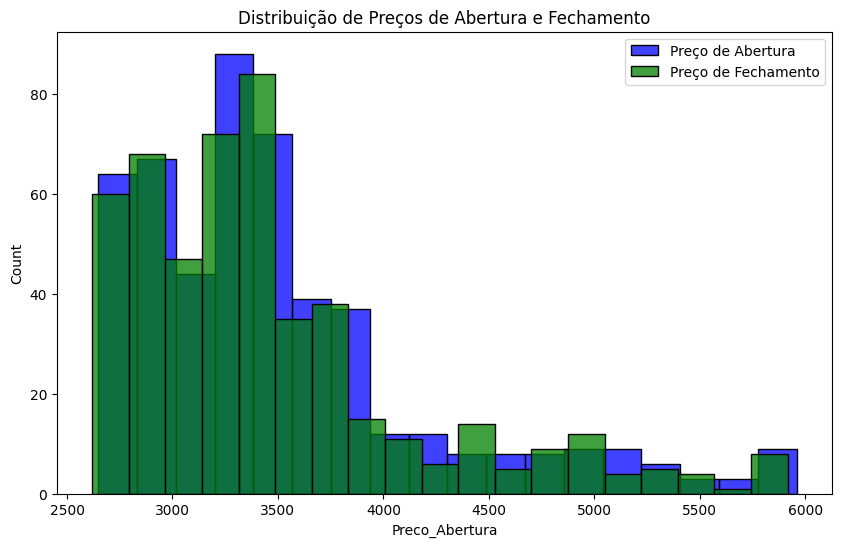

In [117]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df_treino['Preco_Abertura'], ax=ax, color='blue', label='Preço de Abertura')
sns.histplot(df_treino['Preco_Fechamento'], ax=ax, color='green', label='Preço de Fechamento')
plt.title('Distribuição de Preços de Abertura e Fechamento')
plt.legend()
plt.show()

<Axes: xlabel='Data'>

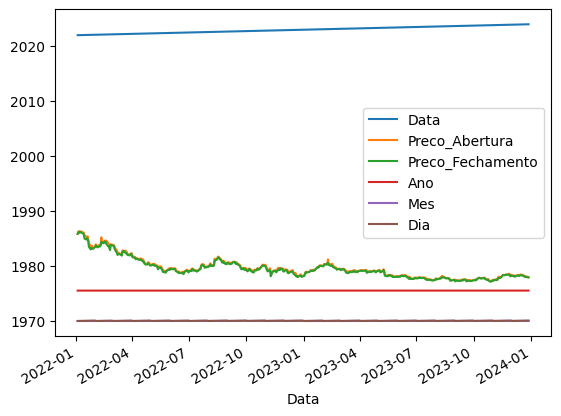

In [118]:
df_treino.plot()

In [119]:
from statsmodels.tsa.stattools import adfuller

adf_test_abertura = adfuller(df_treino['Preco_Abertura'])
# Output the results
print('ADF Statistic Abertura: %f' % adf_test_abertura[0])
print('p-value: %f' % adf_test_abertura[1])

adf_test_fechamento = adfuller(df_treino['Preco_Fechamento'])
# Output the results
print('\nADF Statistic Fechamento: %f' % adf_test_fechamento[0])
print('p-value: %f' % adf_test_fechamento[1])

ADF Statistic Abertura: -3.599541
p-value: 0.005770

ADF Statistic Fechamento: -3.689321
p-value: 0.004266


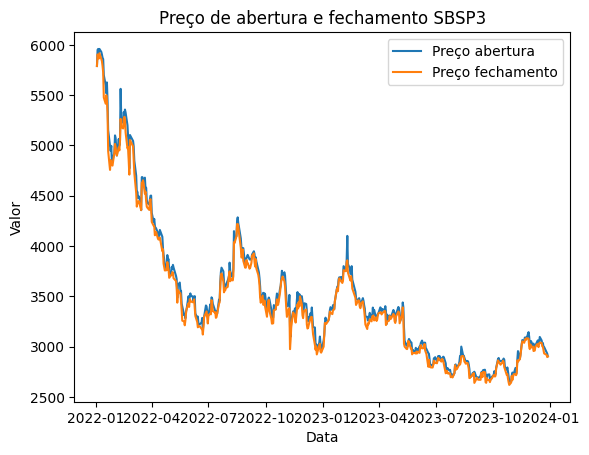

In [120]:
# Plot the time series
plt.plot(df_treino['Preco_Abertura'], label='Preço abertura')
plt.plot(df_treino['Preco_Fechamento'], label='Preço fechamento')
plt.title('Preço de abertura e fechamento SBSP3')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.show()

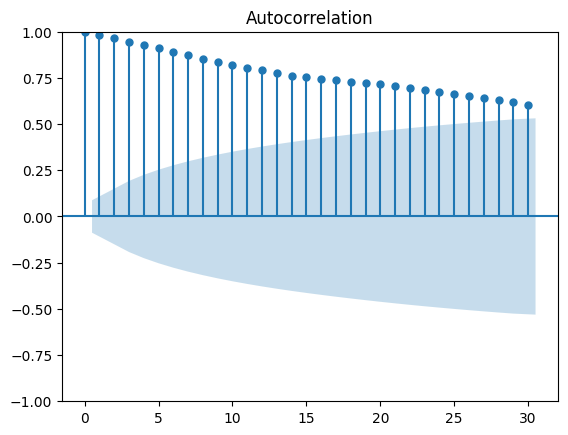

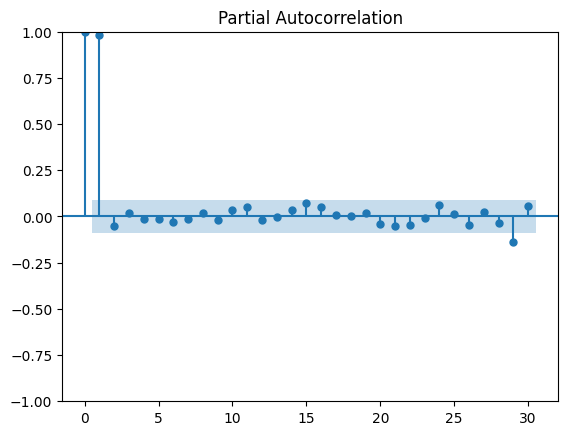

In [121]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_treino['Preco_Abertura'], lags=30)
plot_pacf(df_treino['Preco_Abertura'], lags=30)
plt.show()

In [122]:
# Suavização dos dados
alpha = 0.1
model_exp = SimpleExpSmoothing(df_treino['Preco_Abertura']).fit(smoothing_level=alpha)
df_treino['Preco_Abertura_Suavizado'] = model_exp.fittedvalues
model_exp = SimpleExpSmoothing(df_treino['Preco_Fechamento']).fit(smoothing_level=alpha)
df_treino['Preco_Fechamento_Suavizado'] = model_exp.fittedvalues

df_treino.dropna(inplace=True)

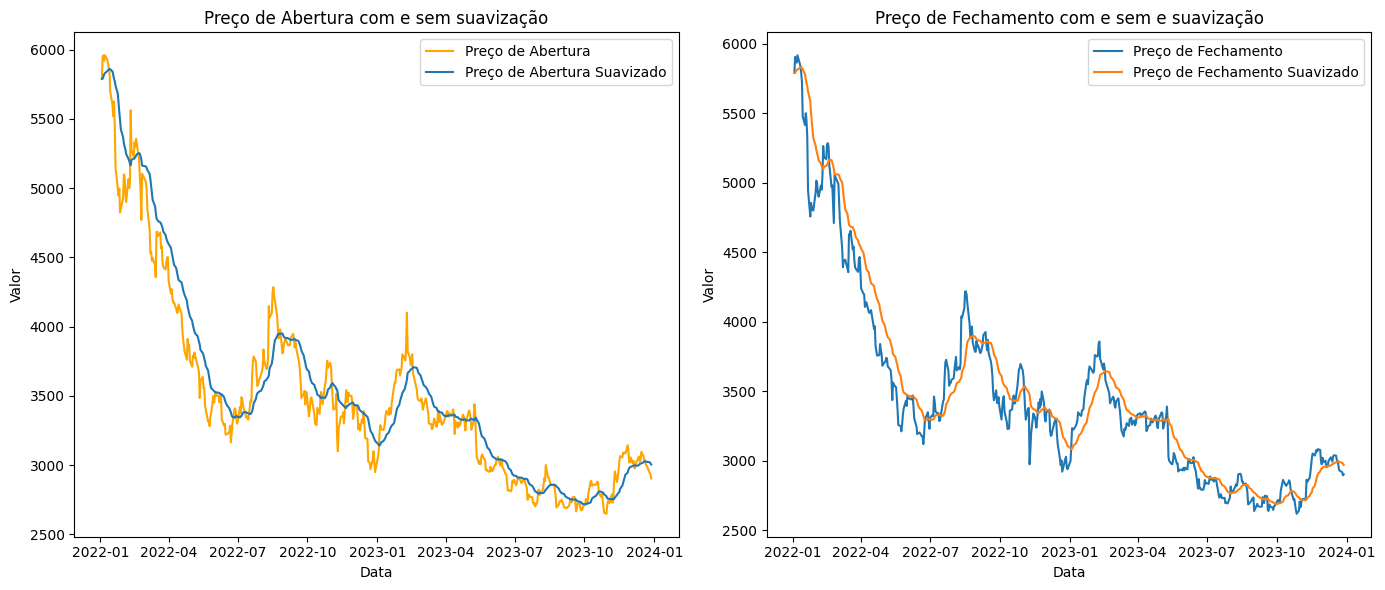

In [123]:
plt.figure(figsize=(14, 6))

# Plotando os dados de abertura
plt.subplot(1, 2, 1)
plt.plot(df_treino.index, df_treino['Preco_Abertura'], label='Preço de Abertura', color='orange')
plt.plot(df_treino.index, df_treino['Preco_Abertura_Suavizado'], label='Preço de Abertura Suavizado')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Preço de Abertura com e sem suavização')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df_treino.index, df_treino['Preco_Fechamento'], label='Preço de Fechamento')
plt.plot(df_treino.index, df_treino['Preco_Fechamento_Suavizado'], label='Preço de Fechamento Suavizado')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Preço de Fechamento com e sem e suavização')
plt.legend()


plt.tight_layout()
plt.show()


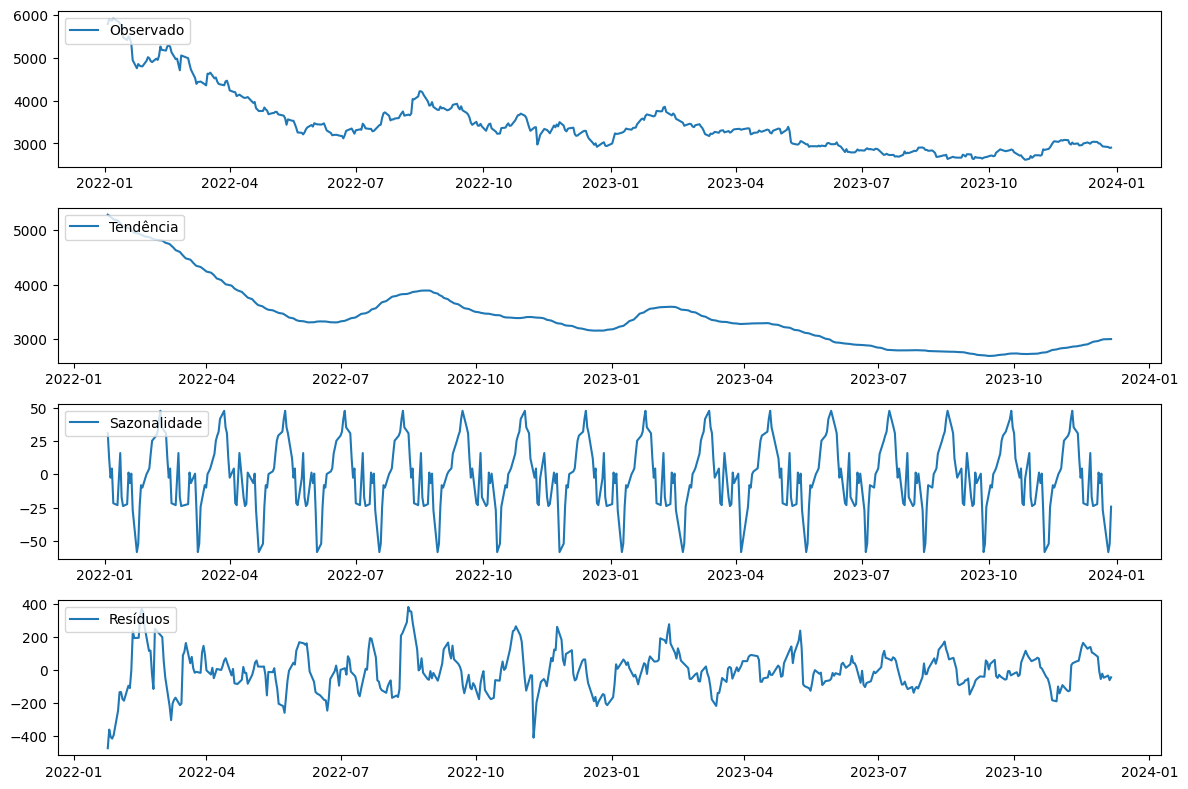

In [124]:
decomposicao = seasonal_decompose(df_treino['Preco_Fechamento'], model='additive', period=30)

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(decomposicao.observed, label='Observado')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposicao.trend, label='Tendência')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposicao.seasonal, label='Sazonalidade')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposicao.resid, label='Resíduos')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [125]:
# Ajustando o modelo ARIMA usando todos os dados de treino
modelo_treino = auto_arima(df_treino['Preco_Fechamento'], seasonal=False, suppress_warnings=True)

# Fazendo previsões até dezembro de 2024
data_final_previsao = '2024-09-30'  # Data final desejada para as previsões
previsoes_finais = modelo_treino.predict(n_periods=(pd.to_datetime(data_final_previsao) - df_treino.index[-1]).days)

# Criando um dataframe para armazenar as previsões
previsoes_df = pd.DataFrame(previsoes_finais, columns=['Previsao'])

# Convertendo o índice para o formato de data
previsoes_df.index = pd.date_range(start=df_treino.index[-1] + pd.Timedelta(days=1), periods=len(previsoes_df), freq='D')

print(previsoes_df)


               Previsao
2023-12-29  2900.262798
2023-12-30  2894.498557
2023-12-31  2888.734315
2024-01-01  2882.970074
2024-01-02  2877.205832
...                 ...
2024-09-26  1332.389106
2024-09-27  1326.624865
2024-09-28  1320.860623
2024-09-29  1315.096382
2024-09-30  1309.332140

[277 rows x 1 columns]


In [142]:
print(previsoes_plt.columns)

Index(['Previsao'], dtype='object')


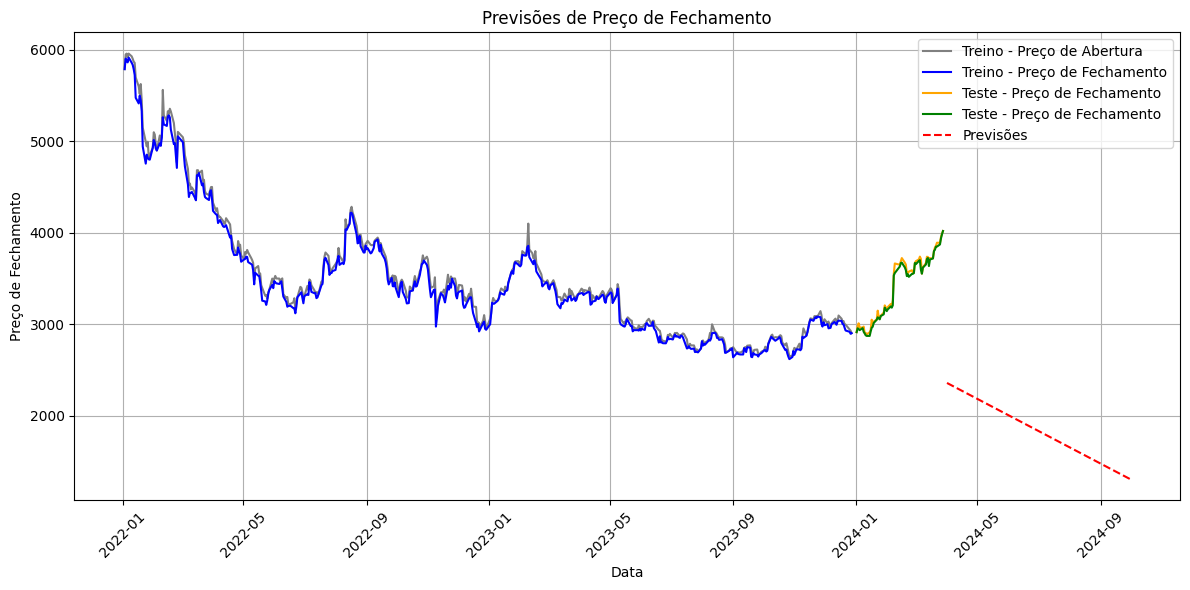

In [146]:
# Definindo o intervalo de datas para incluir os dados de treino, teste e as previsões
previsoes_plt = previsoes_df['2024-04-01':]

# Plot das previsões com maior detalhamento nos meses

plt.figure(figsize=(12, 6))
plt.plot(df_treino.index, df_treino['Preco_Abertura'], label='Treino - Preço de Abertura', color='grey')
plt.plot(df_treino.index, df_treino['Preco_Fechamento'], label='Treino - Preço de Fechamento', color='blue')
plt.plot(df_teste.index, df_teste['Preco_Abertura'], label='Teste - Preço de Fechamento', color='orange')
plt.plot(df_teste.index, df_teste['Preco_Fechamento'], label='Teste - Preço de Fechamento', color='green')
plt.plot(previsoes_plt.index, previsoes_plt['Previsao'], linestyle='--', color='red', label='Previsões')
plt.title('Previsões de Preço de Fechamento')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhorar a legibilidade
plt.legend()
plt.grid(True)
plt.tight_layout()  # Ajusta o layout para evitar sobreposição de elementos
plt.show()


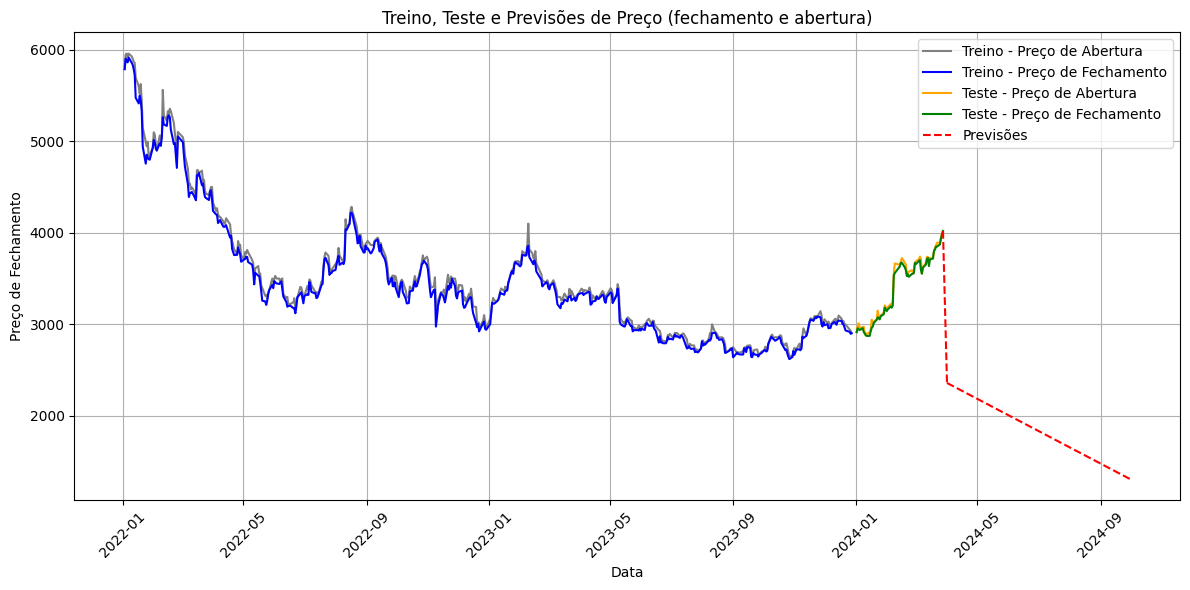

In [148]:
# Definindo o intervalo de datas para incluir os dados de treino, teste e as previsões a partir de abril de 2024
previsoes_plt = previsoes_df['2024-04-01':]

# Plot das previsões com maior detalhamento nos meses
plt.figure(figsize=(12, 6))
plt.plot(df_treino.index, df_treino['Preco_Abertura'], label='Treino - Preço de Abertura', color='grey')
plt.plot(df_treino.index, df_treino['Preco_Fechamento'], label='Treino - Preço de Fechamento', color='blue')
plt.plot(df_teste.index, df_teste['Preco_Abertura'], label='Teste - Preço de Abertura', color='orange')
plt.plot(df_teste.index, df_teste['Preco_Fechamento'], label='Teste - Preço de Fechamento', color='green')
plt.plot(previsoes_plt.index, previsoes_plt['Previsao'], linestyle='--', color='red', label='Previsões')

# Conecte a última data do período de teste à primeira data da previsão
if not df_teste.empty and not previsoes_plt.empty:

    # Obtenha as coordenadas dos pontos de conexão
    x1 = df_teste.index[-1]
    y1 = df_teste.iloc[-1]["Preco_Fechamento"]
    x2 = previsoes_plt.index[0]
    y2 = previsoes_plt.iloc[0]["Previsao"]

    # Crie a linha de conexão
    plt.plot([x1, x2], [y1, y2], linestyle='--', color='red')

else:
    # Exiba uma mensagem se os DataFrames estiverem vazios
    print("Um ou ambos os DataFrames (df_teste, previsoes_plt) estão vazios. Não é possível conectar linhas.")

plt.title('Treino, Teste e Previsões de Preço (fechamento e abertura)')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.xticks(rotation=45) # Rotaciona os rótulos do eixo x para melhorar a legibilidade
plt.legend()
plt.grid(True)
plt.tight_layout() # Ajusta o layout para evitar sobreposição de elementos
plt.show()
